In [16]:
import random

class Ship:
    def __init__(self, size):
        self.size = size
        self.positions = []
        self.hits = 0

    def place_ship(self, board, start_row, start_col, direction):
        """Umieszcza statek na planszy"""
        if direction == "H":
            if start_col + self.size > len(board[0]):
                return False
            for i in range(self.size):
                if board[start_row][start_col + i] != " ":
                    return False
            for i in range(self.size):
                board[start_row][start_col + i] = "S"
                self.positions.append((start_row, start_col + i))
        else:
            if start_row + self.size > len(board):
                return False
            for i in range(self.size):
                if board[start_row + i][start_col] != " ":
                    return False
            for i in range(self.size):
                board[start_row + i][start_col] = "S"
                self.positions.append((start_row + i, start_col))
        return True

    def is_hit(self, row, col):
        """Zwraca True, jeśli statek został trafiony"""
        if (row, col) in self.positions:
            self.hits += 1
            return True
        return False

    def is_sunk(self):
        """Zwraca True, jeśli statek został zatopiony"""
        return self.hits == self.size


class Game:
    def __init__(self, board_size=5):
        self.board_size = board_size
        self.board = [[" " for _ in range(board_size)] for _ in range(board_size)]
        self.ships = []
        self.shots = set()  # Zbiór przechowujący oddane strzały
        self.shot_count = 0  # Zmienna licząca wykonane strzały
        self.hunt_mode = True  # Tryb Hunt (szukamy losowo)
        self.target_stack = []  # Stos celów w trybie Target
        self.last_hit = None  # Ostatnie trafienie (do Target Mode)
        self.probability_grid = [[0 for _ in range(board_size)] for _ in range(board_size)]
        
    def update_probability_grid(self):
        self.probability_grid = [[0 for _ in range(self.board_size)] for _ in range(self.board_size)]
        
        for ship in self.ships:
            if not ship.is_sunk():
                size = ship.size
                
                # Check horizontal placements
                for row in range(self.board_size):
                    for col in range(self.board_size - size + 1):
                        if all(self.board[row][col + i] in [" ", "S"] for i in range(size)):
                            for i in range(size):
                                self.probability_grid[row][col + i] += 1
                
                # Check vertical placements
                for row in range(self.board_size - size + 1):
                    for col in range(self.board_size):
                        if all(self.board[row + i][col] in [" ", "S"] for i in range(size)):
                            for i in range(size):
                                self.probability_grid[row + i][col] += 1
    
    def probability_shot(self):
        max_prob = -1
        target_cell = None
        
        for row in range(self.board_size):
            for col in range(self.board_size):
                if (row, col) not in self.shots and self.probability_grid[row][col] > max_prob:
                    max_prob = self.probability_grid[row][col]
                    target_cell = (row, col)
        
        if target_cell:
            row, col = target_cell
            self.shots.add((row, col))
            #print(f"Strzał na: {row}, {col} (Probability Mode)")
            hit = self.take_shot(row, col)
            self.shot_count += 1
            if hit:
                self.add_adjacent_targets(row, col)
                self.hunt_mode = False  # Przechodzimy do Target Mode
            return hit



    def display_board(self, reveal=False, show_probabilities=False):
        """Wyświetla planszę, jeśli reveal=True, pokazuje położenie statków.
        Jeśli show_probabilities=True, pokazuje prawdopodobieństwa."""
        
        print("  " + " ".join([str(i) for i in range(self.board_size)]))
        
        for i in range(self.board_size):
            if reveal:
                print(str(i) + " " + " ".join(self.board[i]))
            elif show_probabilities:
                print(str(i) + " " + " ".join([str(self.probability_grid[i][j]) for j in range(self.board_size)]))
            else:
                print(str(i) + " " + " ".join(["S" if x == "S" else x for x in self.board[i]]))
            


    def add_ship(self, size):
        """Dodaje statek na planszy"""
        ship = Ship(size)
        placed = False
        while not placed:
            direction = random.choice(["H", "V"])
            start_row = random.randint(0, self.board_size - 1)
            start_col = random.randint(0, self.board_size - 1)
            placed = ship.place_ship(self.board, start_row, start_col, direction)
        self.ships.append(ship)

    def take_shot(self, row, col):
        """Gracz strzela w dane pole"""
        if row < 0 or row >= self.board_size or col < 0 or col >= self.board_size:
            #print("Poza planszą!")
            return False

        if self.board[row][col] == "X" or self.board[row][col] == "O":
            #print("Już tutaj strzelałeś!")
            return False

        hit = False
        for ship in self.ships:
            if ship.is_hit(row, col):
                #print("Trafiony!")
                self.board[row][col] = "X"
                hit = True
                self.last_hit = (row, col)  # Ustaw ostatnie trafienie
                if ship.is_sunk():
                    #print("Zatopiłeś statek!")
                    self.target_stack.clear()  # Wyczyszczenie stosu po zatopieniu
                break

        if not hit:
            #print("Pudło!")
            self.board[row][col] = "O"

        return hit

    def is_game_over(self):
        """Zwraca True, jeśli wszystkie statki zostały zatopione"""
        # print(all(ship.is_sunk() for ship in self.ships))
        return all(ship.is_sunk() for ship in self.ships)

    def add_adjacent_targets(self, row, col):
        """Dodaje sąsiadujące cele do stosu targetów"""
        directions = [(0, 1), (0, -1), (1, 0), (-1, 0)]  # Prawo, lewo, dół, góra
        for dr, dc in directions:
            new_row, new_col = row + dr, col + dc
            if (0 <= new_row < self.board_size and 0 <= new_col < self.board_size and
                    (new_row, new_col) not in self.shots and (new_row, new_col) not in self.target_stack):
                self.target_stack.append((new_row, new_col))

    def random_shot(self):
        """Losowo wybiera nieodwiedzone pole i oddaje strzał"""
        while True:
            row = random.randint(0, self.board_size - 1)
            col = random.randint(0, self.board_size - 1)
            if (row, col) not in self.shots:
                self.shots.add((row, col))
                #print(f"Strzał na: {row}, {col}")
                hit = self.take_shot(row, col)
                self.shot_count += 1  # Zwiększ licznik strzałów
                if hit:
                    self.add_adjacent_targets(row, col)
                    self.hunt_mode = False  # Przechodzimy do Target Mode
                break

    def target_shot(self):
        if self.target_stack:
            row, col = self.target_stack.pop()
            if (row, col) not in self.shots:
                sunk_before = sum(1 for ship in self.ships if ship.is_sunk())
                print(sunk_before)
                self.shots.add((row, col))
                # print(f"Strzał na: {row}, {col} (Target Mode)")
                hit = self.take_shot(row, col)
                self.shot_count += 1
                
                # Sprawdź liczbę zatopionych statków przed strzałem
                
                if hit:
                    self.add_adjacent_targets(row, col)

                # Sprawdź liczbę zatopionych statków po strzale
                sunk_after = sum(1 for ship in self.ships if ship.is_sunk())
                print(sunk_after)
                # Zmień tryb tylko, jeśli liczba zatopionych statków wzrosła
                if sunk_after > sunk_before:
                    print("Zatopiony")
                    self.target_stack.clear()  # Wyczyść stos celów
                    self.hunt_mode = True  # Wróć do trybu Hunt
                    return

                if not self.target_stack:
                    self.hunt_mode = True  # Wracamy do Hunt Mode, jeśli brak targetów
                return
        else:
            self.hunt_mode = True


    def start_game(self, ship_sizes, strategy='random'):
        """Starts the game with the selected shooting strategy."""
        for size in ship_sizes:
            self.add_ship(size)

        while not self.is_game_over():
            self.update_probability_grid()
            self.display_board(reveal=True)
            self.display_board(show_probabilities=True)
            if self.hunt_mode:
                print("propability")
                self.probability_shot()
            else:
                print("hunt_mode")
                self.target_shot()  # Celowane strzały w trybie Target



  0 1 2 3 4 5 6 7 8 9
0     S         S    
1     S         S    
2     S         S    
3 S             S   S
4 S       S     S   S
5 S       S         S
6                   S
7                    
8                    
9                    
  0 1 2 3 4 5 6 7 8 9
0 10 15 19 21 22 22 21 19 15 10
1 15 20 24 26 27 27 26 24 20 15
2 19 24 28 30 31 31 30 28 24 19
3 21 26 30 32 33 33 32 30 26 21
4 22 27 31 33 34 34 33 31 27 22
5 22 27 31 33 34 34 33 31 27 22
6 21 26 30 32 33 33 32 30 26 21
7 19 24 28 30 31 31 30 28 24 19
8 15 20 24 26 27 27 26 24 20 15
9 10 15 19 21 22 22 21 19 15 10
propability
  0 1 2 3 4 5 6 7 8 9
0     S         S    
1     S         S    
2     S         S    
3 S             S   S
4 S       X     S   S
5 S       S         S
6                   S
7                    
8                    
9                    
  0 1 2 3 4 5 6 7 8 9
0 10 15 19 21 21 22 21 19 15 10
1 15 20 24 26 24 27 26 24 20 15
2 19 24 28 30 24 31 30 28 24 19
3 21 26 30 32 21 33 32 30 26 21
4 21 24 24 2

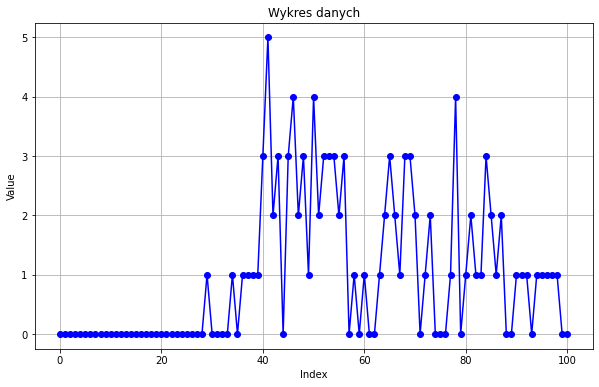

In [18]:
import matplotlib.pyplot as plt

if __name__ == "__main__":
    results = [0] * 101  # Lista 100 elementów, reprezentująca liczbę gier zakończonych w danej liczbie strzałów

    for _ in range(1000):  # Przeprowadzenie 1000 gier
        game = Game(board_size=10)  # Rozmiar planszy 10x10
        game.start_game([2, 3, 3,4,5],'probability')  # Statki o rozmiarach 2, 3, 3, 4, 5
        # print(game.shot_count)
        # Jeśli liczba strzałów nie przekracza 100, zaktualizuj wyniki
        if game.shot_count < 101:
            results[game.shot_count] += 1
        else:
            print(game.shot_count)

    print(results)  # Wyświetlenie wyników
    data=results
    plt.figure(figsize=(10, 6))
    plt.plot(data, marker='o', linestyle='-', color='b')

    # Dodawanie etykiet
    plt.title('Wykres danych')
    plt.xlabel('Index')
    plt.ylabel('Value')

    # Wyświetlenie wykresu
    plt.grid(True)
    plt.show()